In [1359]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse
from pylab import rcParams
pd.set_option('display.max_columns',None)
import warnings
warnings.filterwarnings('ignore')

# data

In [1360]:
data_owid = pd.read_csv("./dataset/owid-energy-data.csv")

In [1361]:
data_owid

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,biofuel_electricity,biofuel_share_elec,biofuel_share_energy,carbon_intensity_elec,coal_cons_change_pct,coal_cons_change_twh,coal_cons_per_capita,coal_consumption,coal_elec_per_capita,coal_electricity,coal_prod_change_pct,coal_prod_change_twh,coal_prod_per_capita,coal_production,coal_share_elec,coal_share_energy,electricity_demand,electricity_demand_per_capita,electricity_generation,electricity_share_energy,energy_cons_change_pct,energy_cons_change_twh,energy_per_capita,energy_per_gdp,fossil_cons_change_pct,fossil_cons_change_twh,fossil_elec_per_capita,fossil_electricity,fossil_energy_per_capita,fossil_fuel_consumption,fossil_share_elec,fossil_share_energy,gas_cons_change_pct,gas_cons_change_twh,gas_consumption,gas_elec_per_capita,gas_electricity,gas_energy_per_capita,gas_prod_change_pct,gas_prod_change_twh,gas_prod_per_capita,gas_production,gas_share_elec,gas_share_energy,greenhouse_gas_emissions,hydro_cons_change_pct,hydro_cons_change_twh,hydro_consumption,hydro_elec_per_capita,hydro_electricity,hydro_energy_per_capita,hydro_share_elec,hydro_share_energy,low_carbon_cons_change_pct,low_carbon_cons_change_twh,low_carbon_consumption,low_carbon_elec_per_capita,low_carbon_electricity,low_carbon_energy_per_capita,low_carbon_share_elec,low_carbon_share_energy,net_elec_imports,net_elec_imports_share_demand,nuclear_cons_change_pct,nuclear_cons_change_twh,nuclear_consumption,nuclear_elec_per_capita,nuclear_electricity,nuclear_energy_per_capita,nuclear_share_elec,nuclear_share_energy,oil_cons_change_pct,oil_cons_change_twh,oil_consumption,oil_elec_per_capita,oil_electricity,oil_energy_per_capita,oil_prod_change_pct,oil_prod_change_twh,oil_prod_per_capita,oil_production,oil_share_elec,oil_share_energy,other_renewable_consumption,other_renewable_electricity,other_renewable_exc_biofuel_electricity,other_renewables_cons_change_pct,other_renewables_cons_change_twh,other_renewables_elec_per_capita,other_renewables_elec_per_capita_exc_biofuel,other_renewables_energy_per_capita,other_renewables_share_elec,other_renewables_share_elec_exc_biofuel,other_renewables_share_energy,per_capita_electricity,primary_energy_consumption,renewables_cons_change_pct,renewables_cons_change_twh,renewables_consumption,renewables_elec_per_capita,renewables_electricity,renewables_energy_per_capita,renewables_share_elec,renewables_share_energy,solar_cons_change_pct,solar_cons_change_twh,solar_consumption,solar_elec_per_capita,solar_electricity,solar_energy_per_capita,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
0,ASEAN (Ember),2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.87,1.550,NaN,569.557,NaN,NaN,NaN,NaN,NaN,76.03,NaN,NaN,NaN,NaN,20.081,NaN,378.61,NaN,378.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,305.36,NaN,NaN,80.653,NaN,NaN,NaN,NaN,NaN,164.26,NaN,NaN,NaN,NaN,NaN,43.385,NaN,215.64,NaN,NaN,NaN,NaN,50.45,NaN,13.325,NaN,NaN,NaN,NaN,NaN,73.25,NaN,19.347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,65.07,NaN,NaN,NaN,NaN,NaN,17.187,NaN,NaN,22.80,16.93,NaN,NaN,NaN,NaN,NaN,6.022,4.472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.25,NaN,19.347,NaN,NaN,NaN,NaN,NaN,0.00,NaN,0.000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
1,ASEAN (Ember),2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.46,1.596,NaN,567.642,NaN,NaN,NaN,NaN,NaN,86.26,NaN,NaN,NaN,NaN,21.307,NaN,404.85,NaN,404.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,327.66,NaN,NaN,80.934,NaN,NaN,NaN,NaN,NaN,190.41,NaN,NaN,NaN,NaN,NaN,47.032,NaN,229.81,NaN,NaN,NaN,NaN,54.33,NaN,13.420,NaN,NaN,NaN,NaN,NaN,77.19,NaN,19.066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,50.99,NaN,NaN,NaN,NaN,NaN,12.595,NaN,NaN,22.86,16.40,NaN,NaN,NaN,NaN,NaN,5.647,4.051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.19,NaN,19.066,NaN,NaN,NaN,NaN,NaN,0.00,NaN,0.000,NaN,NaN,NaN,NaN,NaN,0.0,NaN

## historical data for EDA

In [1362]:
cpi = pd.read_csv('./dataset/consumer-price-index.csv')

In [1363]:
cpi

,Entity,Code,Year,Consumer price index (2010 = 100)
0,Italy,ITA,1960,4.147836
1,Italy,ITA,1961,4.232895
2,Italy,ITA,1962,4.431467
3,Italy,ITA,1963,4.761820
4,Italy,ITA,1964,5.043354
...,...,...,...,...
59,Italy,ITA,2019,110.623600
60,Italy,ITA,2020,110.471260
61,Italy,ITA,2021,112.541250
62,Italy,ITA,2022,121.771090


In [1364]:
cpi = cpi[['Year','Consumer price index (2010 = 100)']].reset_index(drop=True)

In [1365]:
cpi['Year'] = pd.to_datetime(cpi['Year'],format='%Y')

In [1366]:
cpi = cpi.rename(columns={'Consumer price index (2010 = 100)':'cpi','Year':'year'})

In [1367]:
cpi = cpi.set_index('year').dropna()

In [1368]:
cpi

,cpi
year,
1960-01-01,4.147836
1961-01-01,4.232895
1962-01-01,4.431467
1963-01-01,4.761820
1964-01-01,5.043354
...,...
2019-01-01,110.623600
2020-01-01,110.471260
2021-01-01,112.541250


In [1369]:
co2 = pd.read_csv('./dataset/annual-co2-emissions-per-country.csv')

In [1370]:
co2

,Entity,Code,Year,Annual CO₂ emissions
0,Italy,ITA,1860,29312.0
1,Italy,ITA,1861,670512.0
2,Italy,ITA,1862,1227440.0
3,Italy,ITA,1863,1069888.0
4,Italy,ITA,1864,1604832.0
...,...,...,...,...
159,Italy,ITA,2019,339633540.0
160,Italy,ITA,2020,302602430.0
161,Italy,ITA,2021,335977820.0
162,Italy,ITA,2022,340672300.0


In [1371]:
co2 = co2[['Year','Annual CO₂ emissions']].reset_index(drop=True)

In [1372]:
co2['Year'] = pd.to_datetime(co2['Year'],format='%Y')

In [1373]:
co2 = co2.rename(columns={'Annual CO₂ emissions':'co2','Year':'year'})

In [1374]:
co2 = co2.set_index('year').dropna()

In [1375]:
co2

,co2
year,
1860-01-01,29312.0
1861-01-01,670512.0
1862-01-01,1227440.0
1863-01-01,1069888.0
1864-01-01,1604832.0
...,...
2019-01-01,339633540.0
2020-01-01,302602430.0
2021-01-01,335977820.0


In [1376]:
density = pd.read_csv('./dataset/population-density.csv')

In [1377]:
density

,Entity,Code,Year,Population density
0,Italy,ITA,1400,27.066790
1,Italy,ITA,1500,30.448635
2,Italy,ITA,1600,44.898500
3,Italy,ITA,1700,45.602116
4,Italy,ITA,1710,47.004980
...,...,...,...,...
309,Italy,ITA,2096,122.844600
310,Italy,ITA,2097,122.036360
311,Italy,ITA,2098,121.236260
312,Italy,ITA,2099,120.438385


In [1378]:
density = density[['Year','Population density']].loc[density['Year'] >= 1931].reset_index(drop=True)

In [1379]:
density['Year'] = pd.to_datetime(density['Year'],format='%Y')

In [1380]:
density = density.rename(columns={'Population density':'density','Year':'year'})

In [1381]:
density = density.set_index('year').dropna()

In [1382]:
density

,density
year,
1931-01-01,136.959120
1932-01-01,138.116010
1933-01-01,139.273390
1934-01-01,140.440480
1935-01-01,141.617320
...,...
2096-01-01,122.844600
2097-01-01,122.036360
2098-01-01,121.236260


In [1383]:
precipitation = pd.read_csv('./dataset/average-precipitation-per-year.csv')

In [1384]:
precipitation

,Entity,Code,Year,Annual precipitation
0,Italy,ITA,1931,980.4897
1,Italy,ITA,1932,876.2479
2,Italy,ITA,1933,986.2547
3,Italy,ITA,1934,874.7829
4,Italy,ITA,1935,987.7974
...,...,...,...,...
89,Italy,ITA,2020,981.3541
90,Italy,ITA,2021,990.3465
91,Italy,ITA,2022,818.1664
92,Italy,ITA,2023,1025.3726


In [1385]:
precipitation = precipitation[['Year','Annual precipitation']].reset_index(drop=True)

In [1386]:
precipitation['Year'] = pd.to_datetime(precipitation['Year'],format='%Y')

In [1387]:
precipitation = precipitation.rename(columns={'Annual precipitation':'precipitation','Year':'year'})

In [1388]:
precipitation = precipitation.set_index('year').dropna()

In [1389]:
precipitation

,precipitation
year,
1931-01-01,980.4897
1932-01-01,876.2479
1933-01-01,986.2547
1934-01-01,874.7829
1935-01-01,987.7974
...,...
2020-01-01,981.3541
2021-01-01,990.3465
2022-01-01,818.1664


In [1390]:
temperature = pd.read_csv('./dataset/annual-temperature-anomalies.csv')

In [1391]:
temperature

,Entity,Code,Year,Temperature anomaly
0,Italy,ITA,1931,-2.784570
1,Italy,ITA,1932,-2.762485
2,Italy,ITA,1933,-2.598746
3,Italy,ITA,1934,-2.625348
4,Italy,ITA,1935,-2.685322
...,...,...,...,...
89,Italy,ITA,2020,0.610705
90,Italy,ITA,2021,0.337167
91,Italy,ITA,2022,1.275581
92,Italy,ITA,2023,1.230895


In [1392]:
temperature = temperature[['Year','Temperature anomaly']].reset_index(drop=True)

In [1393]:
temperature['Year'] = pd.to_datetime(temperature['Year'],format='%Y')

In [1394]:
temperature = temperature.rename(columns={'Temperature anomaly':'temperature_anomaly','Year':'year'})

In [1395]:
temperature = temperature.set_index('year').dropna()

In [1396]:
temperature

,temperature_anomaly
year,
1931-01-01,-2.784570
1932-01-01,-2.762485
1933-01-01,-2.598746
1934-01-01,-2.625348
1935-01-01,-2.685322
...,...
2020-01-01,0.610705
2021-01-01,0.337167
2022-01-01,1.275581


In [1397]:
historical_data = data_owid.loc[(data_owid['year'] > 1930) & (data_owid['year'] < 2015) & (data_owid['country'] == 'Italy')]

In [1398]:
historical_data

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,biofuel_electricity,biofuel_share_elec,biofuel_share_energy,carbon_intensity_elec,coal_cons_change_pct,coal_cons_change_twh,coal_cons_per_capita,coal_consumption,coal_elec_per_capita,coal_electricity,coal_prod_change_pct,coal_prod_change_twh,coal_prod_per_capita,coal_production,coal_share_elec,coal_share_energy,electricity_demand,electricity_demand_per_capita,electricity_generation,electricity_share_energy,energy_cons_change_pct,energy_cons_change_twh,energy_per_capita,energy_per_gdp,fossil_cons_change_pct,fossil_cons_change_twh,fossil_elec_per_capita,fossil_electricity,fossil_energy_per_capita,fossil_fuel_consumption,fossil_share_elec,fossil_share_energy,gas_cons_change_pct,gas_cons_change_twh,gas_consumption,gas_elec_per_capita,gas_electricity,gas_energy_per_capita,gas_prod_change_pct,gas_prod_change_twh,gas_prod_per_capita,gas_production,gas_share_elec,gas_share_energy,greenhouse_gas_emissions,hydro_cons_change_pct,hydro_cons_change_twh,hydro_consumption,hydro_elec_per_capita,hydro_electricity,hydro_energy_per_capita,hydro_share_elec,hydro_share_energy,low_carbon_cons_change_pct,low_carbon_cons_change_twh,low_carbon_consumption,low_carbon_elec_per_capita,low_carbon_electricity,low_carbon_energy_per_capita,low_carbon_share_elec,low_carbon_share_energy,net_elec_imports,net_elec_imports_share_demand,nuclear_cons_change_pct,nuclear_cons_change_twh,nuclear_consumption,nuclear_elec_per_capita,nuclear_electricity,nuclear_energy_per_capita,nuclear_share_elec,nuclear_share_energy,oil_cons_change_pct,oil_cons_change_twh,oil_consumption,oil_elec_per_capita,oil_electricity,oil_energy_per_capita,oil_prod_change_pct,oil_prod_change_twh,oil_prod_per_capita,oil_production,oil_share_elec,oil_share_energy,other_renewable_consumption,other_renewable_electricity,other_renewable_exc_biofuel_electricity,other_renewables_cons_change_pct,other_renewables_cons_change_twh,other_renewables_elec_per_capita,other_renewables_elec_per_capita_exc_biofuel,other_renewables_energy_per_capita,other_renewables_share_elec,other_renewables_share_elec_exc_biofuel,other_renewables_share_energy,per_capita_electricity,primary_energy_consumption,renewables_cons_change_pct,renewables_cons_change_twh,renewables_consumption,renewables_elec_per_capita,renewables_electricity,renewables_energy_per_capita,renewables_share_elec,renewables_share_energy,solar_cons_change_pct,solar_cons_change_twh,solar_consumption,solar_elec_per_capita,solar_electricity,solar_energy_per_capita,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
9980,Italy,1931,ITA,40501139.0,1.866570e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-14.549,-0.479,69.411,2.811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000,0.093,4.594,0.186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9981,Italy,1932,ITA,40843255.0,1.906655e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.543,0.184,73.333,2.995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.750,0.128,7.688,0.314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9982,Italy,1933,ITA,41185511.0,1.884730e+11,N

In [1399]:
data = pd.read_csv("./dataset/energy.csv") # produzione lorda e consumo di energia elettrica in Italia - Anni 1883-2014 (milioni di kWh)

In [1400]:
data

,year,tot_production,tot_consumption,agricultural,industry,transports,public_lighting,services,domestic_uses
0,1931,"10,470","8,335",103,"6,213",803,209,"1,007",0
1,1932,"10,590","8,420",103,"6,223",845,225,"1,024",0
2,1933,"11,650","9,293",114,"6,984",860,243,"1,092",0
3,1934,"12,600","10,159",110,"7,684",879,258,"1,228",0
4,1935,"13,800","11,168",138,"8,583","1,003",267,"1,177",0
...,...,...,...,...,...,...,...,...,...
79,2010,"302,062","309,885","5,610","138,439","10,666","6,366","79,253","69,551"
80,2011,"302,570","313,792","5,907","140,040","10,720","6,202","80,783","70,140"
81,2012,"299,275","307,220","5,923","130,801","10,759","6,261","84,019","69,457"
82,2013,"289,803","297,288","5,677","124,871","10,774","5,977","83,005","66,983"


In [1401]:
historical_data = historical_data.reset_index(drop=True)

In [1402]:
data = data.reset_index(drop=True)

In [1403]:
data['population'] = historical_data['population']

In [1404]:
data['gdp'] = historical_data['gdp']

In [1405]:
data.tail()

,year,tot_production,tot_consumption,agricultural,industry,transports,public_lighting,services,domestic_uses,population,gdp
79,2010,"302,062","309,885","5,610","138,439","10,666","6,366","79,253","69,551",59822452.0,2.080546e+12
80,2011,"302,570","313,792","5,907","140,040","10,720","6,202","80,783","70,140",60025952.0,2.110883e+12
81,2012,"299,275","307,220","5,923","130,801","10,759","6,261","84,019","69,457",60190152.0,2.047960e+12
82,2013,"289,803","297,288","5,677","124,871","10,774","5,977","83,005","66,983",60312600.0,2.010255e+12
83,2014,"279,829","291,084","5,372","122,505","10,462","5,885","82,604","64,255",60322792.0,2.010164e+12


In [1406]:
for col in data.columns:
    if data[col].dtype == 'O':  
        data[col] = data[col].str.replace(',', '', regex=False)
        data[col] = pd.to_numeric(data[col], errors='coerce')

In [1407]:
data['year'] = pd.to_datetime(data['year'],format='%Y')

In [1408]:
data.set_index('year',inplace=True)

In [1409]:
data = data.merge(co2,left_index=True,right_index=True,how='left')

In [1410]:
data = data.merge(density,left_index=True,right_index=True,how='left')

In [1411]:
data = data.merge(precipitation,left_index=True,right_index=True,how='left')

In [1412]:
data = data.merge(temperature,left_index=True,right_index=True,how='left')

In [1413]:
data['per_capita_co2'] = data['co2'] / data['population'] 

In [1414]:
data['per_capita_gdp'] = data['gdp'] / data['population'] 

In [1415]:
data['per_capita_consumption'] = data['tot_consumption'] / data['population']

In [1416]:
data

,tot_production,tot_consumption,agricultural,industry,transports,public_lighting,services,domestic_uses,population,gdp,co2,density,precipitation,temperature_anomaly,per_capita_co2,per_capita_gdp,per_capita_consumption
year,,,,,,,,,,,,,,,,,
1931-01-01,10470,8335,103,6213,803,209,1007,0,40501139.0,1.866570e+11,34172700.0,136.95912,980.48970,-2.784570,0.843747,4608.685542,0.000206
1932-01-01,10590,8420,103,6223,845,225,1024,0,40843255.0,1.906655e+11,28064604.0,138.11601,876.24790,-2.762485,0.687129,4668.223864,0.000206
1933-01-01,11650,9293,114,6984,860,243,1092,0,41185511.0,1.884730e+11,30473790.0,139.27339,986.25470,-2.598746,0.739915,4576.197903,0.000226
1934-01-01,12600,10159,110,7684,879,258,1228,0,41530635.0,1.879873e+11,39660990.0,140.44048,874.78290,-2.625348,0.954982,4526.474142,0.000245
1935-01-01,13800,11168,138,8583,1003,267,1177,0,41878651.0,1.981434e+11,45376240.0,141.61732,987.79740,-2.685322,1.083517,4731.370802,0.000267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-01-01,302062,309885,5610,138439,10666,6366,79253,69551,59822452.0,2.080546e+12,435710340.0,203.45181,1322.84860,-0.527131,7.283392,34778.680821,0.005180
2011-01-01,302570,313792,5907,140040,10720,6202,80783,70140,60025952.0,2.110883e+12,423894300.0,204.14055,878.00850,0.283001,7.061851,35166.178870,0.005228
2012-01-01,299275,307220,5923,130801,10759,6261,84019,69457,60190152.0,2.047960e+12,403441340.0,204.69395,1010.26935,0.307669,6.702780,34024.833364,0.005104


In [1417]:
data.drop(['gdp','population','co2'],axis=1,inplace=True)

In [1418]:
data

,tot_production,tot_consumption,agricultural,industry,transports,public_lighting,services,domestic_uses,density,precipitation,temperature_anomaly,per_capita_co2,per_capita_gdp,per_capita_consumption
year,,,,,,,,,,,,,,
1931-01-01,10470,8335,103,6213,803,209,1007,0,136.95912,980.48970,-2.784570,0.843747,4608.685542,0.000206
1932-01-01,10590,8420,103,6223,845,225,1024,0,138.11601,876.24790,-2.762485,0.687129,4668.223864,0.000206
1933-01-01,11650,9293,114,6984,860,243,1092,0,139.27339,986.25470,-2.598746,0.739915,4576.197903,0.000226
1934-01-01,12600,10159,110,7684,879,258,1228,0,140.44048,874.78290,-2.625348,0.954982,4526.474142,0.000245
1935-01-01,13800,11168,138,8583,1003,267,1177,0,141.61732,987.79740,-2.685322,1.083517,4731.370802,0.000267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-01-01,302062,309885,5610,138439,10666,6366,79253,69551,203.45181,1322.84860,-0.527131,7.283392,34778.680821,0.005180
2011-01-01,302570,313792,5907,140040,10720,6202,80783,70140,204.14055,878.00850,0.283001,7.061851,35166.178870,0.005228
2012-01-01,299275,307220,5923,130801,10759,6261,84019,69457,204.69395,1010.26935,0.307669,6.702780,34024.833364,0.005104


<Axes: xlabel='year'>

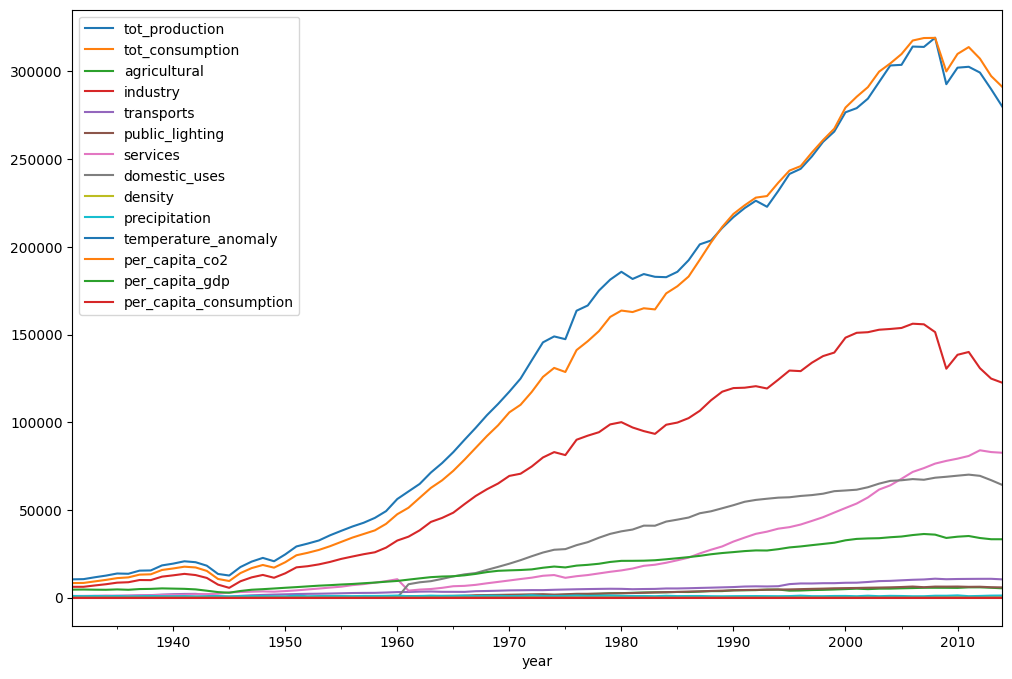

In [1419]:
data.plot(figsize=(12,8))

In [1420]:
data.columns

Index(['tot_production', 'tot_consumption', 'agricultural', 'industry',
       'transports', 'public_lighting', 'services', 'domestic_uses', 'density',
       'precipitation', 'temperature_anomaly', 'per_capita_co2',
       'per_capita_gdp', 'per_capita_consumption'],
      dtype='object')

<Axes: xlabel='year'>

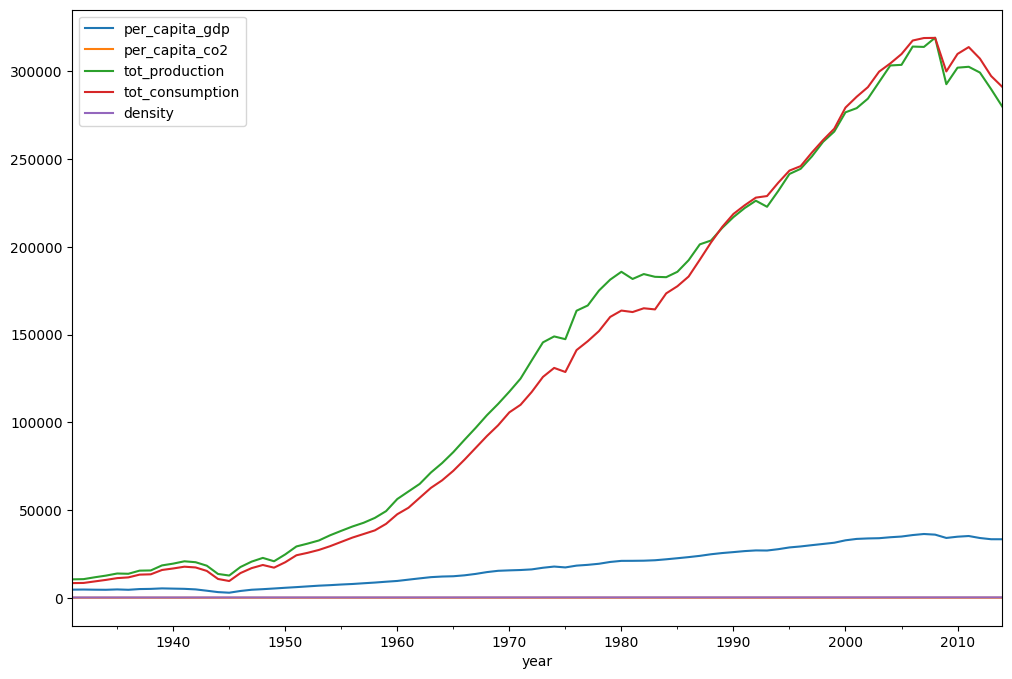

In [1421]:
data[['per_capita_gdp','per_capita_co2','tot_production','tot_consumption','density']].plot(figsize=(12,8))

<Axes: xlabel='year'>

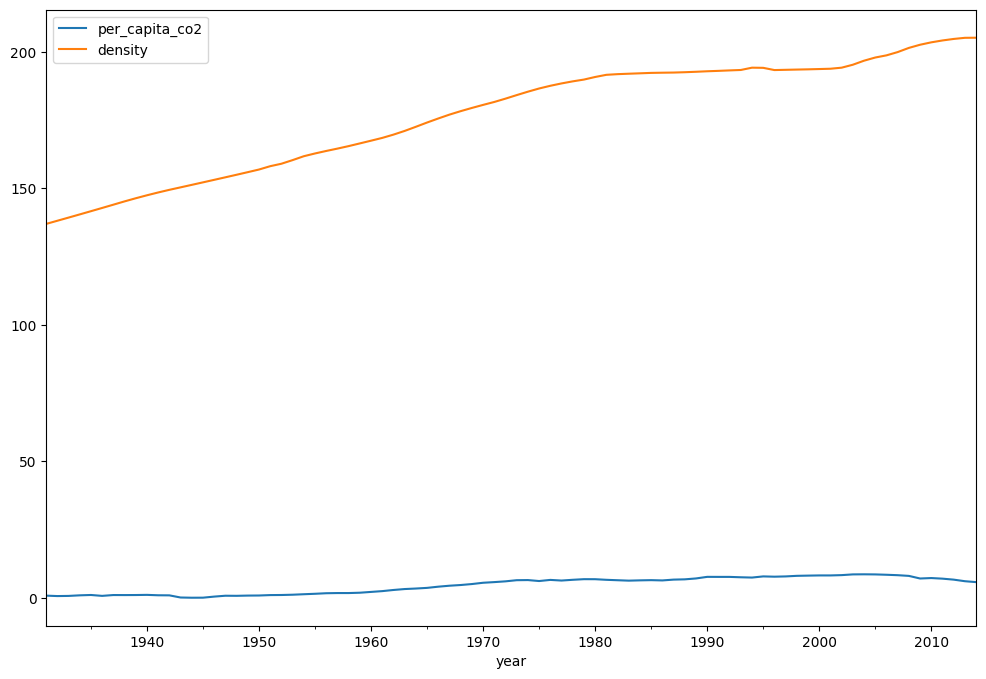

In [1422]:
data[['per_capita_co2','density']].plot(figsize=(12,8))

In [1423]:
prod_cycle,prod_trend = hpfilter(data['tot_production'])

<Axes: xlabel='year'>

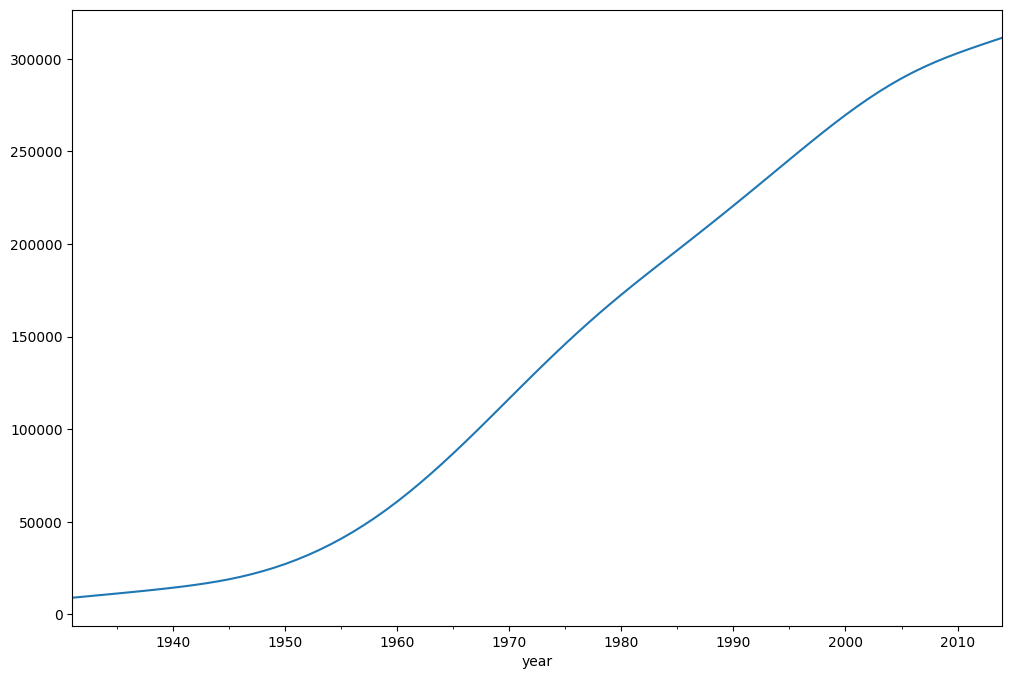

In [1424]:
prod_trend.plot(figsize=(12,8))

In [1425]:
data['production_trend'] = prod_trend

<Axes: xlabel='year'>

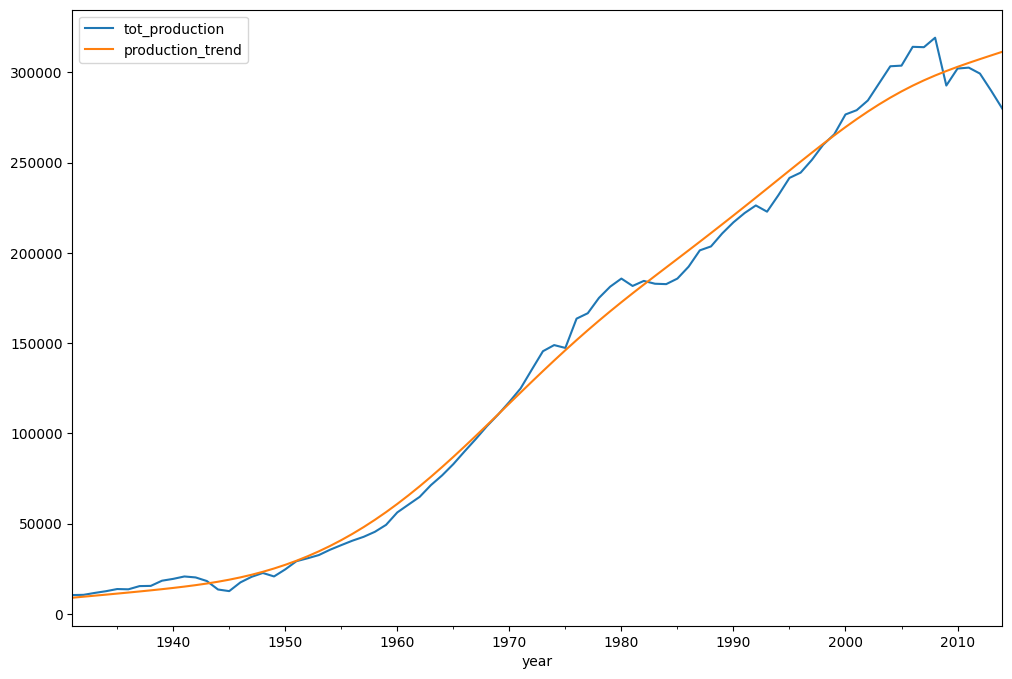

In [1426]:
data[['tot_production','production_trend']].plot(figsize=(12,8))

In [1427]:
cons_cycle,cons_trend = hpfilter(data['tot_consumption'])

In [1428]:
data['consumption_trend'] = cons_trend

<Axes: xlabel='year'>

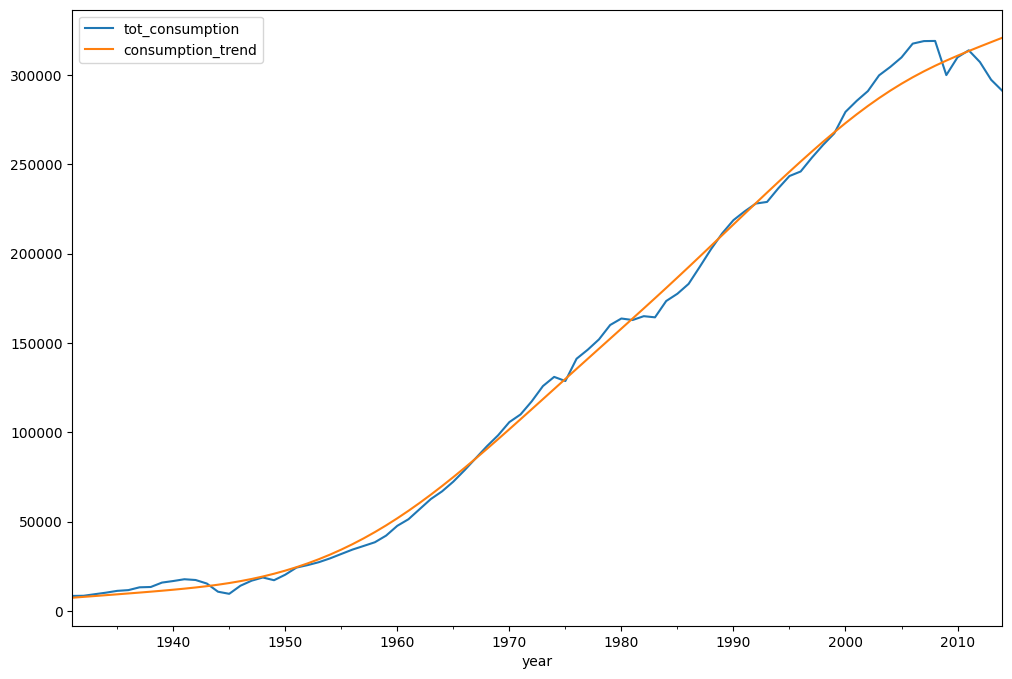

In [1429]:
data[['tot_consumption','consumption_trend']].plot(figsize=(12,8))

<Axes: xlabel='year'>

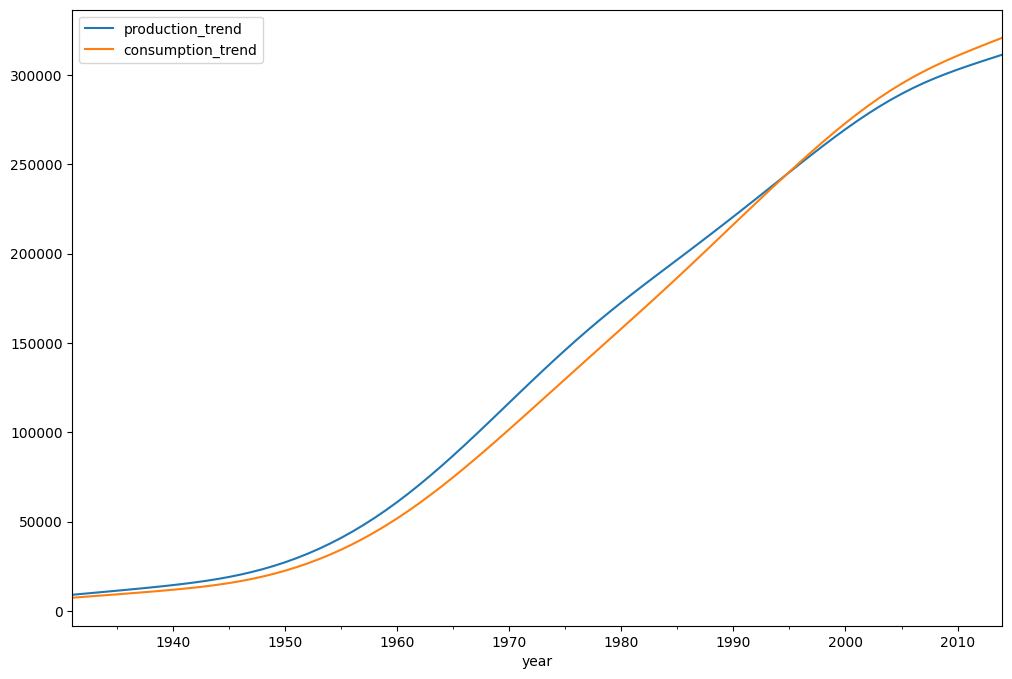

In [1430]:
data[['production_trend','consumption_trend']].plot(figsize=(12,8))

<Axes: xlabel='year'>

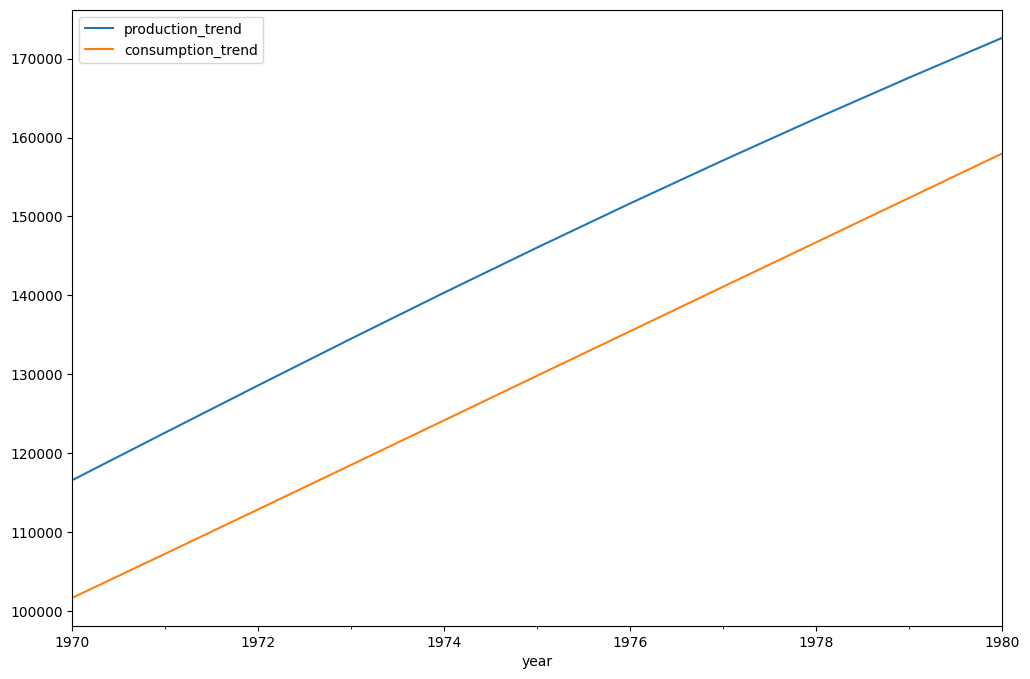

In [1431]:
data[['production_trend','consumption_trend']].loc['1970-01-01':'1980-01-01'].plot(figsize=(12,8))

In [1432]:
data['5-year-MA'] = data['tot_production'].rolling(window=5).mean()

In [1433]:
data['10-year-MA'] = data['tot_production'].rolling(window=10).mean()

<Axes: xlabel='year'>

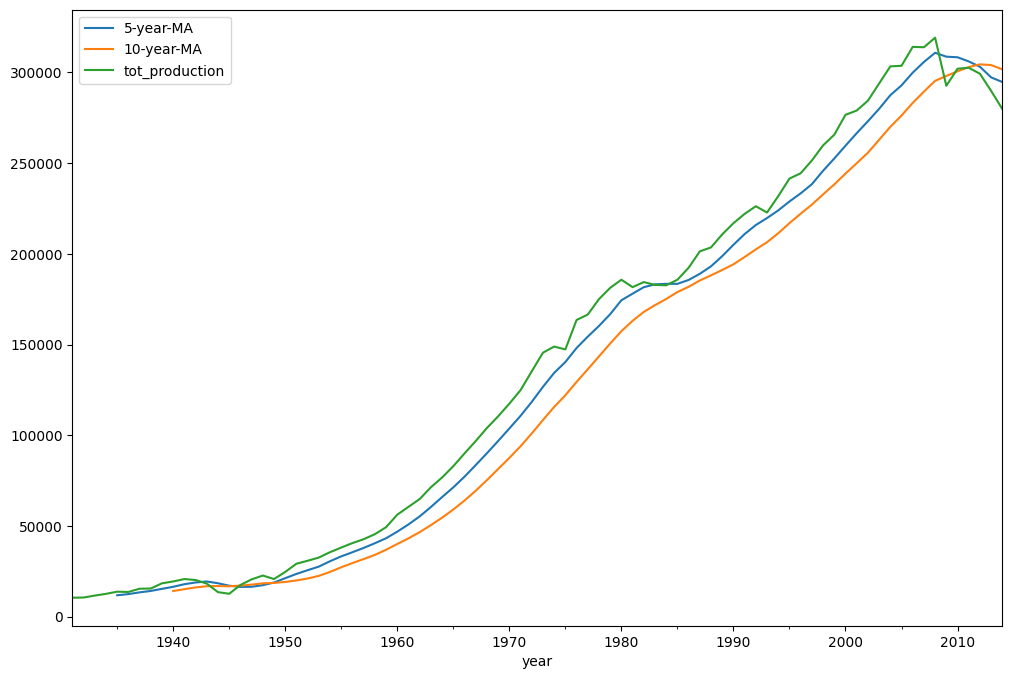

In [1434]:
data[['5-year-MA','10-year-MA','tot_production']].plot(figsize=(12,8))

In [1435]:
data.drop(['production_trend', 'consumption_trend','5-year-MA', '10-year-MA'],axis=1,inplace=True)

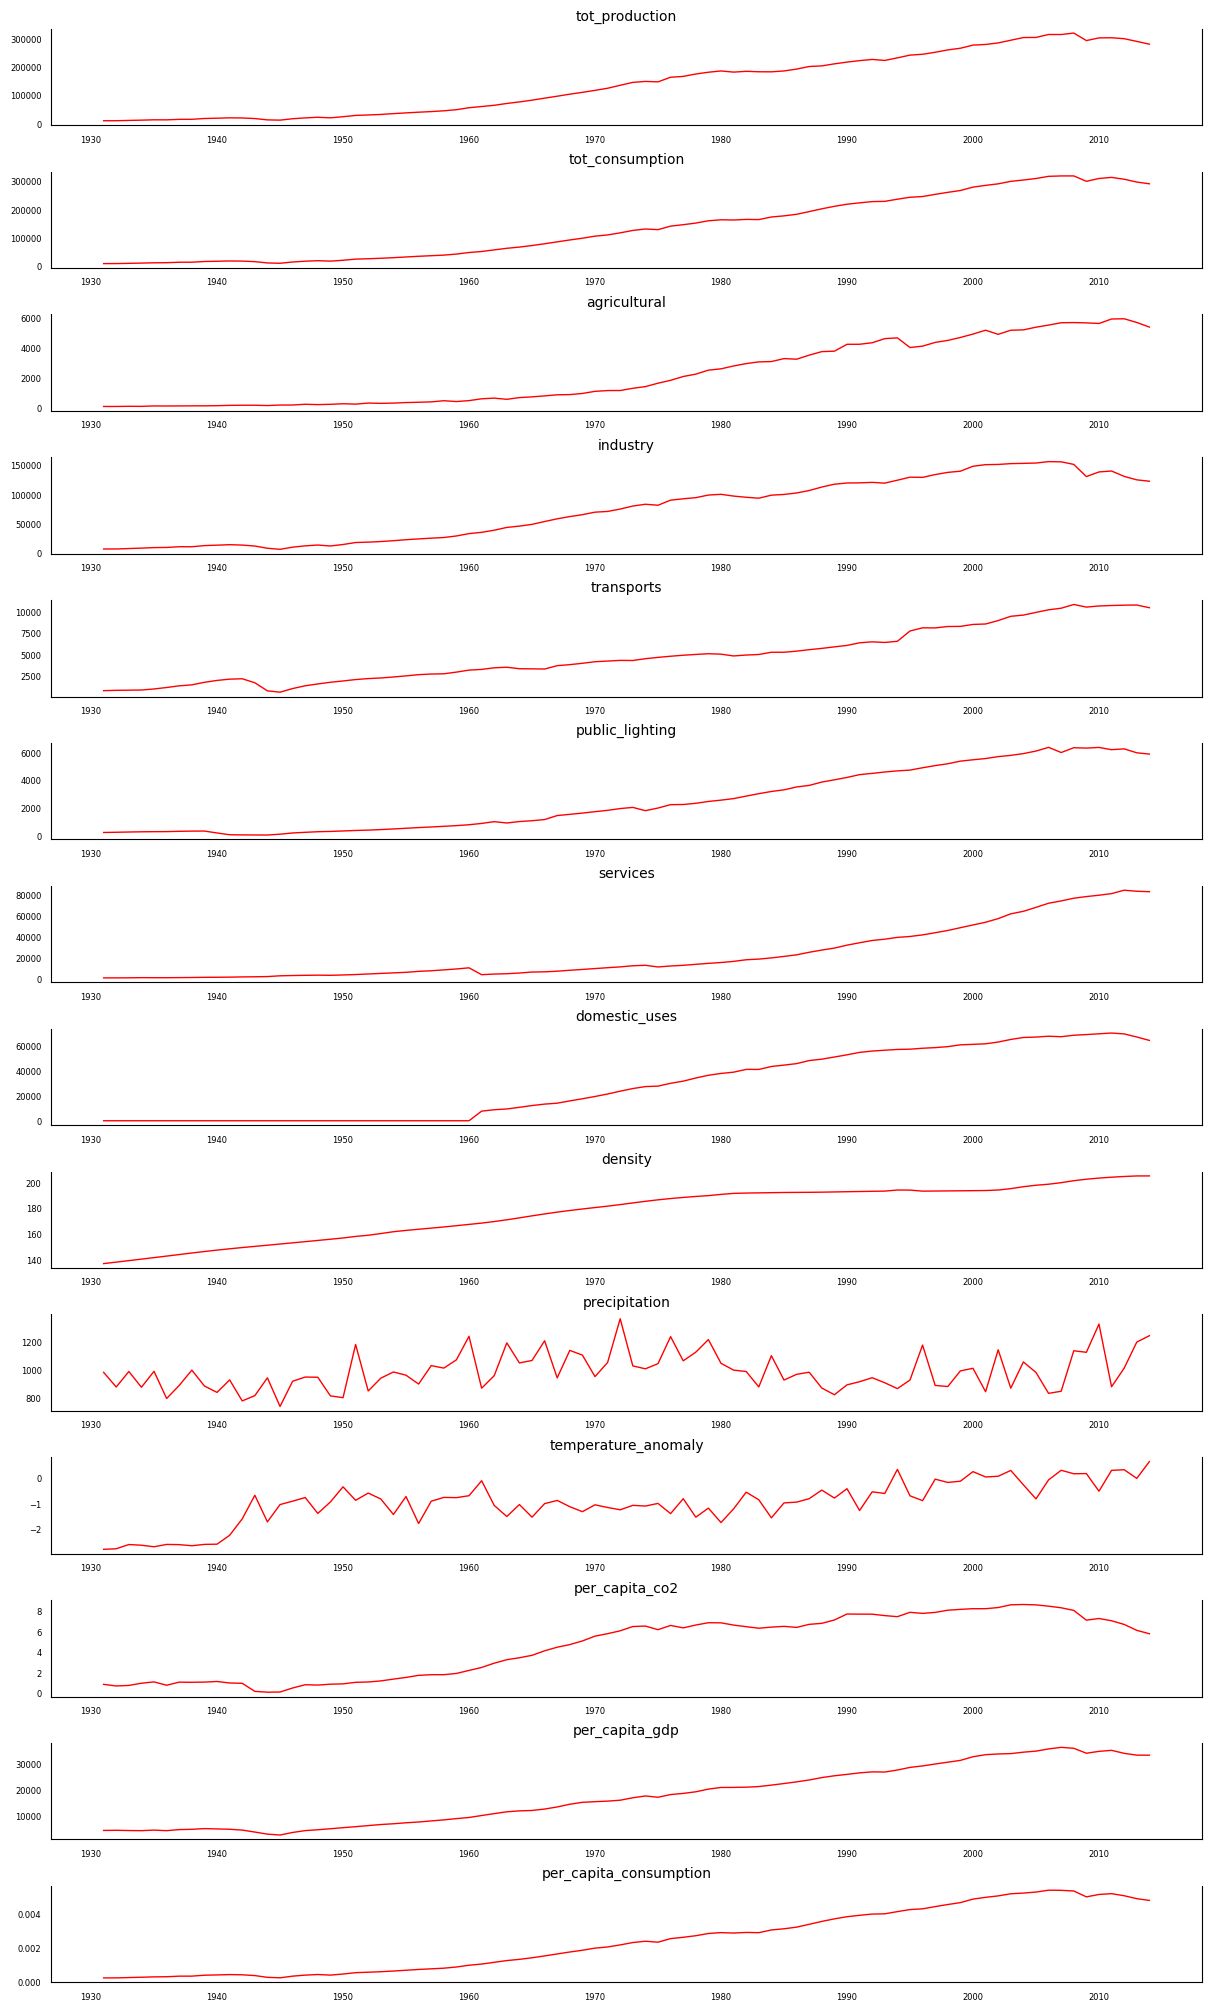

In [1436]:
fig, axes = plt.subplots(nrows=data.shape[1],figsize=(12, 20),constrained_layout=True)

for i, ax in enumerate(axes):
    data_ = data[data.columns[i]]
    
    ax.plot(data_, color='red', linewidth=1)
    ax.set_title(data.columns[i], fontsize=10)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.show()

In [1437]:
result = seasonal_decompose(data['tot_production'])

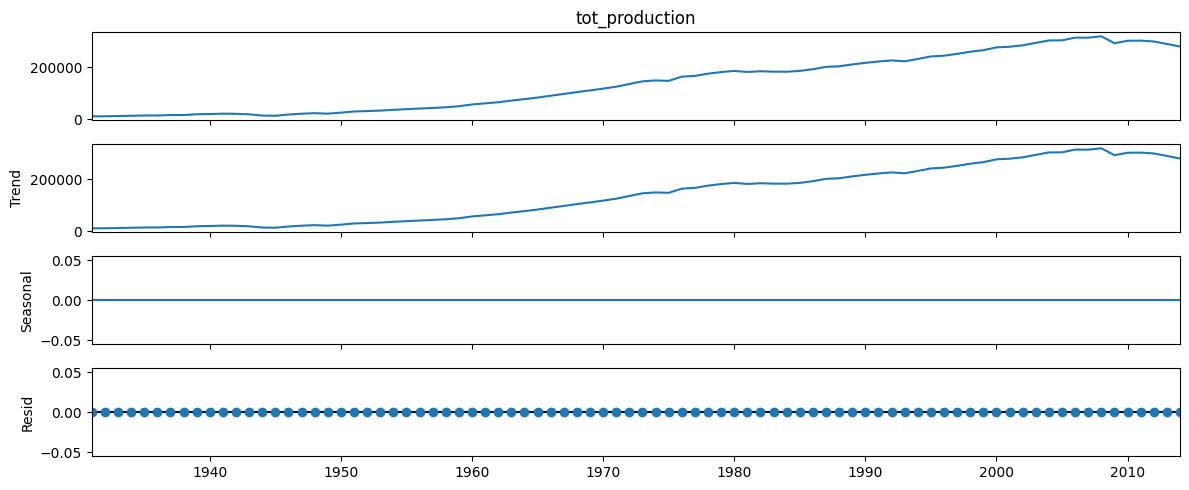

In [1438]:
rcParams['figure.figsize'] = 12,5
result.plot();

In [1439]:
result = seasonal_decompose(data['tot_consumption'])

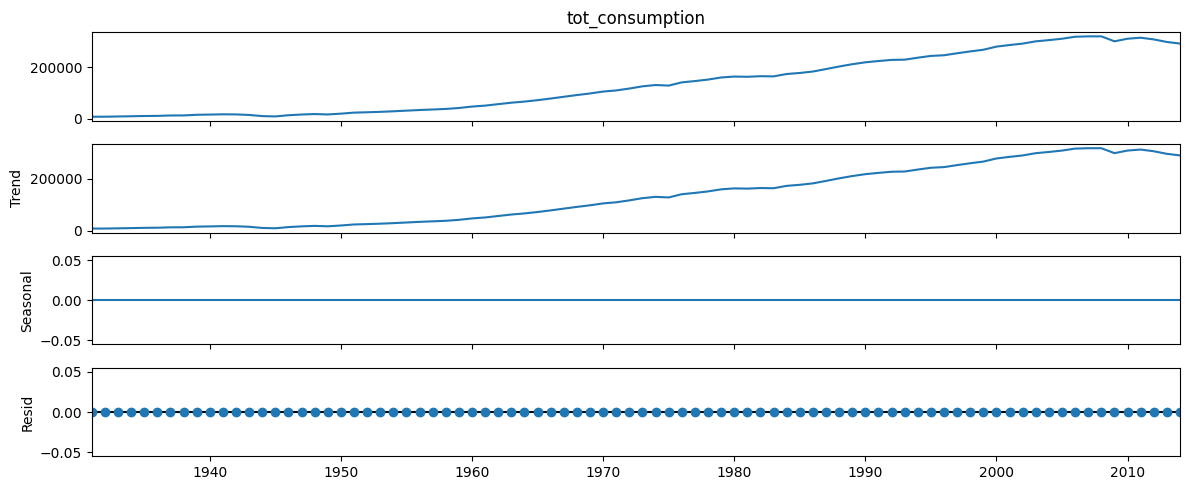

In [1440]:
rcParams['figure.figsize'] = 12,5
result.plot();

## data for VAR model

In [1441]:
data_owid_italy = data_owid[data_owid['country'] == 'Italy'].copy()

In [1442]:
data_owid_italy

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,biofuel_electricity,biofuel_share_elec,biofuel_share_energy,carbon_intensity_elec,coal_cons_change_pct,coal_cons_change_twh,coal_cons_per_capita,coal_consumption,coal_elec_per_capita,coal_electricity,coal_prod_change_pct,coal_prod_change_twh,coal_prod_per_capita,coal_production,coal_share_elec,coal_share_energy,electricity_demand,electricity_demand_per_capita,electricity_generation,electricity_share_energy,energy_cons_change_pct,energy_cons_change_twh,energy_per_capita,energy_per_gdp,fossil_cons_change_pct,fossil_cons_change_twh,fossil_elec_per_capita,fossil_electricity,fossil_energy_per_capita,fossil_fuel_consumption,fossil_share_elec,fossil_share_energy,gas_cons_change_pct,gas_cons_change_twh,gas_consumption,gas_elec_per_capita,gas_electricity,gas_energy_per_capita,gas_prod_change_pct,gas_prod_change_twh,gas_prod_per_capita,gas_production,gas_share_elec,gas_share_energy,greenhouse_gas_emissions,hydro_cons_change_pct,hydro_cons_change_twh,hydro_consumption,hydro_elec_per_capita,hydro_electricity,hydro_energy_per_capita,hydro_share_elec,hydro_share_energy,low_carbon_cons_change_pct,low_carbon_cons_change_twh,low_carbon_consumption,low_carbon_elec_per_capita,low_carbon_electricity,low_carbon_energy_per_capita,low_carbon_share_elec,low_carbon_share_energy,net_elec_imports,net_elec_imports_share_demand,nuclear_cons_change_pct,nuclear_cons_change_twh,nuclear_consumption,nuclear_elec_per_capita,nuclear_electricity,nuclear_energy_per_capita,nuclear_share_elec,nuclear_share_energy,oil_cons_change_pct,oil_cons_change_twh,oil_consumption,oil_elec_per_capita,oil_electricity,oil_energy_per_capita,oil_prod_change_pct,oil_prod_change_twh,oil_prod_per_capita,oil_production,oil_share_elec,oil_share_energy,other_renewable_consumption,other_renewable_electricity,other_renewable_exc_biofuel_electricity,other_renewables_cons_change_pct,other_renewables_cons_change_twh,other_renewables_elec_per_capita,other_renewables_elec_per_capita_exc_biofuel,other_renewables_energy_per_capita,other_renewables_share_elec,other_renewables_share_elec_exc_biofuel,other_renewables_share_energy,per_capita_electricity,primary_energy_consumption,renewables_cons_change_pct,renewables_cons_change_twh,renewables_consumption,renewables_elec_per_capita,renewables_electricity,renewables_energy_per_capita,renewables_share_elec,renewables_share_energy,solar_cons_change_pct,solar_cons_change_twh,solar_consumption,solar_elec_per_capita,solar_electricity,solar_energy_per_capita,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
9949,Italy,1900,ITA,33332371.0,1.099054e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.112,1.170,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.698,0.023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9950,Italy,1901,ITA,33571430.0,1.123700e+11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-11.250,-0.132,30.940,1.039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.000,0.693,0.023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9951,Italy,1902,ITA,33827207.0,1.151736e+11,NaN,NaN,NaN,Na

In [1443]:
data_owid_italy['year'] = pd.to_datetime(data_owid_italy['year'],format='%Y')

In [1444]:
exclude_cols = ['electricity_demand','electricity_generation','net_elec_imports','carbon_intensity_elec','per_capita_electricity','electricity_demand_per_capita',
                'electricity_share_energy','net_elec_imports_share_demand']

cols = [col for col in data_owid_italy.columns if 'electricity' in col and col not in exclude_cols]

data_owid_electricity = pd.concat(
    [data_owid_italy[['year','population','gdp'] + exclude_cols],data_owid_italy[cols]],axis=1).set_index('year').dropna()

In [1445]:
data_owid_share_elec = pd.concat(
     [data_owid_italy[['year','electricity_demand','electricity_generation']],
     data_owid_italy.filter(like='share_elec',axis=1)],axis=1).set_index('year').dropna()

In [1446]:
data_owid_electricity = data_owid_electricity.merge(cpi,left_index=True,right_index=True,how='left')

In [1447]:
data_owid_electricity.head() # electricity generation from xxx measured in terawatt-hours

,population,gdp,electricity_demand,electricity_generation,net_elec_imports,carbon_intensity_elec,per_capita_electricity,electricity_demand_per_capita,electricity_share_energy,net_elec_imports_share_demand,biofuel_electricity,coal_electricity,fossil_electricity,gas_electricity,hydro_electricity,low_carbon_electricity,nuclear_electricity,oil_electricity,other_renewable_electricity,other_renewable_exc_biofuel_electricity,renewables_electricity,solar_electricity,wind_electricity,cpi
year,,,,,,,,,,,,,,,,,,,,,,,,
1990-01-01,56756560.0,1.475485e+12,247.80,213.15,34.65,564.251,3755.513,4366.015,11.928,13.983,0.05,32.05,178.25,39.71,31.63,34.90,0.0,106.49,3.27,3.22,34.90,0.00,0.00,55.838990
1991-01-01,56794488.0,1.509176e+12,253.51,218.43,35.08,533.764,3845.972,4463.637,11.973,13.838,0.11,28.50,172.90,36.34,42.24,45.53,0.0,108.06,3.29,3.18,45.53,0.00,0.00,59.328926
1992-01-01,56833184.0,1.531924e+12,257.98,222.68,35.30,527.214,3918.133,4539.250,12.261,13.683,0.10,21.36,176.91,35.48,42.20,45.77,0.0,120.07,3.56,3.46,45.77,0.01,0.00,62.455914
1993-01-01,56869456.0,1.529550e+12,259.17,219.74,39.43,517.566,3863.937,4557.280,12.366,15.214,0.12,16.66,174.52,39.96,41.42,45.22,0.0,117.90,3.79,3.67,45.22,0.01,0.00,65.345580
1994-01-01,56883820.0,1.573415e+12,266.35,228.75,37.60,517.814,4021.354,4682.351,12.947,14.117,0.15,19.86,180.50,40.80,44.66,48.25,0.0,119.84,3.57,3.42,48.25,0.01,0.01,67.993280


In [1448]:
data_owid_electricity.head()

,population,gdp,electricity_demand,electricity_generation,net_elec_imports,carbon_intensity_elec,per_capita_electricity,electricity_demand_per_capita,electricity_share_energy,net_elec_imports_share_demand,biofuel_electricity,coal_electricity,fossil_electricity,gas_electricity,hydro_electricity,low_carbon_electricity,nuclear_electricity,oil_electricity,other_renewable_electricity,other_renewable_exc_biofuel_electricity,renewables_electricity,solar_electricity,wind_electricity,cpi
year,,,,,,,,,,,,,,,,,,,,,,,,
1990-01-01,56756560.0,1.475485e+12,247.80,213.15,34.65,564.251,3755.513,4366.015,11.928,13.983,0.05,32.05,178.25,39.71,31.63,34.90,0.0,106.49,3.27,3.22,34.90,0.00,0.00,55.838990
1991-01-01,56794488.0,1.509176e+12,253.51,218.43,35.08,533.764,3845.972,4463.637,11.973,13.838,0.11,28.50,172.90,36.34,42.24,45.53,0.0,108.06,3.29,3.18,45.53,0.00,0.00,59.328926
1992-01-01,56833184.0,1.531924e+12,257.98,222.68,35.30,527.214,3918.133,4539.250,12.261,13.683,0.10,21.36,176.91,35.48,42.20,45.77,0.0,120.07,3.56,3.46,45.77,0.01,0.00,62.455914
1993-01-01,56869456.0,1.529550e+12,259.17,219.74,39.43,517.566,3863.937,4557.280,12.366,15.214,0.12,16.66,174.52,39.96,41.42,45.22,0.0,117.90,3.79,3.67,45.22,0.01,0.00,65.345580
1994-01-01,56883820.0,1.573415e+12,266.35,228.75,37.60,517.814,4021.354,4682.351,12.947,14.117,0.15,19.86,180.50,40.80,44.66,48.25,0.0,119.84,3.57,3.42,48.25,0.01,0.01,67.993280


In [1449]:
data_owid_share_elec.head() # share of electricity generated by xxx measured as a percentage of total electricity

,electricity_demand,electricity_generation,biofuel_share_elec,coal_share_elec,fossil_share_elec,gas_share_elec,hydro_share_elec,low_carbon_share_elec,nuclear_share_elec,oil_share_elec,other_renewables_share_elec,other_renewables_share_elec_exc_biofuel,renewables_share_elec,solar_share_elec,wind_share_elec
year,,,,,,,,,,,,,,,
1990-01-01,247.80,213.15,0.023,15.036,83.627,18.630,14.839,16.373,0.0,49.960,1.534,1.511,16.373,0.000,0.000
1991-01-01,253.51,218.43,0.050,13.048,79.156,16.637,19.338,20.844,0.0,49.471,1.506,1.456,20.844,0.000,0.000
1992-01-01,257.98,222.68,0.045,9.592,79.446,15.933,18.951,20.554,0.0,53.920,1.599,1.554,20.554,0.004,0.000
1993-01-01,259.17,219.74,0.055,7.582,79.421,18.185,18.850,20.579,0.0,53.654,1.725,1.670,20.579,0.005,0.000
1994-01-01,266.35,228.75,0.066,8.682,78.907,17.836,19.523,21.093,0.0,52.389,1.561,1.495,21.093,0.004,0.004


<Axes: xlabel='year'>

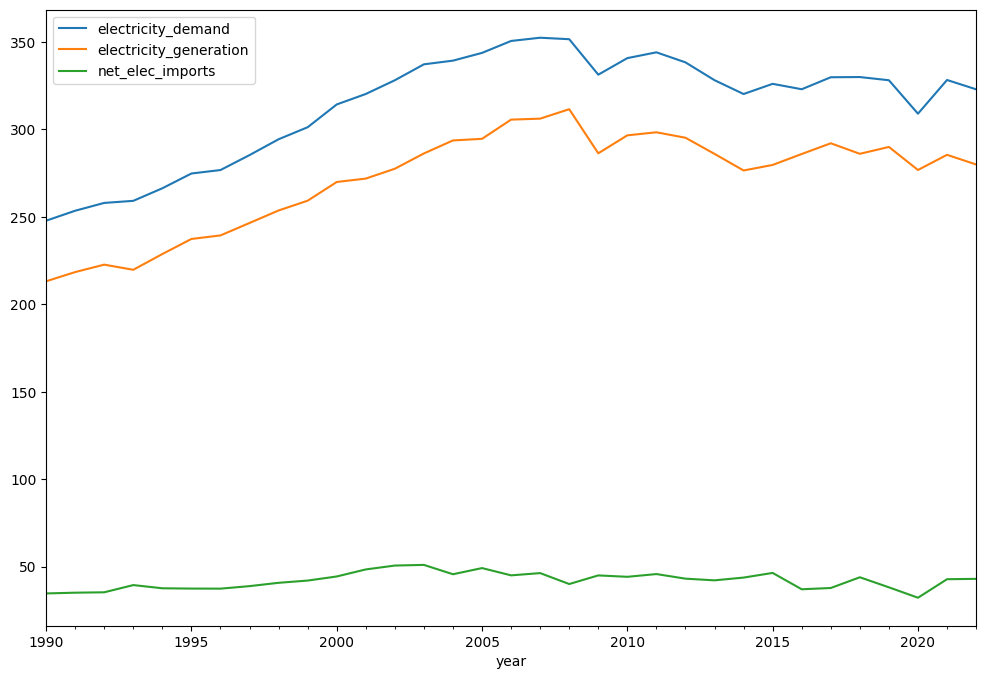

In [1450]:
data_owid_electricity[['electricity_demand','electricity_generation','net_elec_imports']].plot(figsize=(12,8))

<Axes: xlabel='year'>

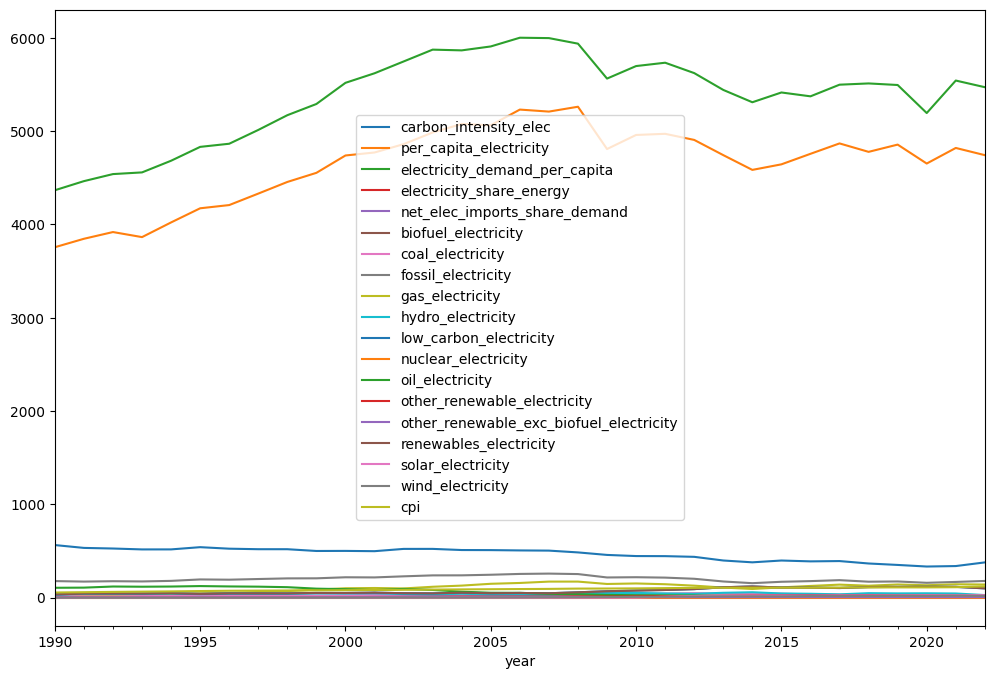

In [1451]:
data_owid_electricity.drop(['population','gdp','electricity_demand','electricity_generation','net_elec_imports'],axis=1).plot(figsize=(12,8))

<Axes: xlabel='year'>

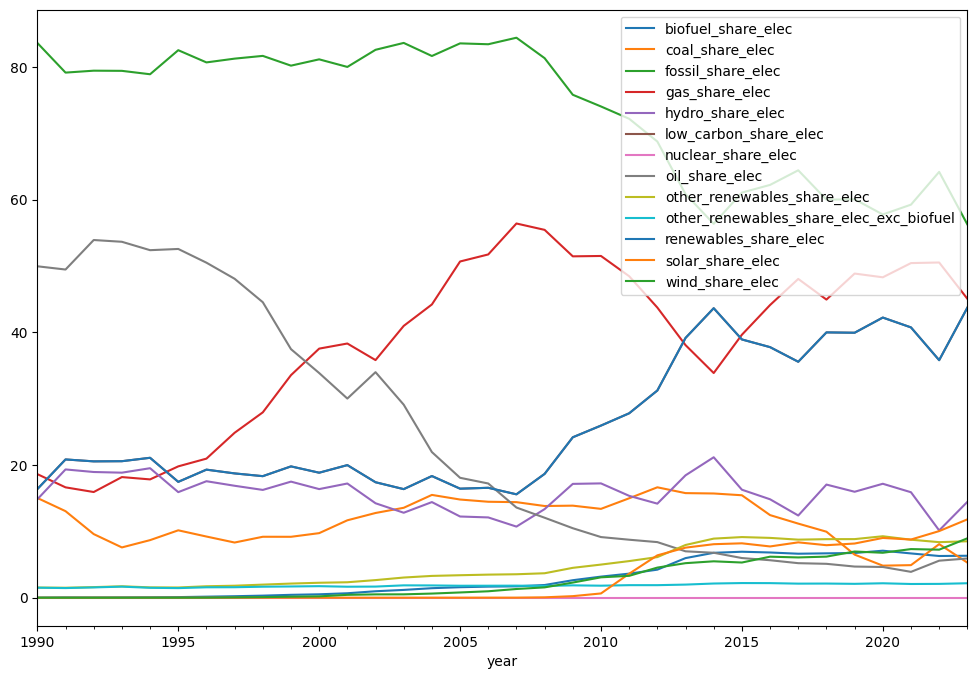

In [1452]:
data_owid_share_elec.drop(['electricity_demand','electricity_generation'],axis=1).plot(figsize=(12,8))

In [1453]:
data_owid_electricity['per_capita_gdp'] = data_owid_electricity['gdp'] / data_owid_electricity['population']

In [1454]:
data_owid_electricity['per_capita_gdp'] = data_owid_electricity['per_capita_gdp'] / 100

## var model dataset

In [1455]:
data.head()

,tot_production,tot_consumption,agricultural,industry,transports,public_lighting,services,domestic_uses,density,precipitation,temperature_anomaly,per_capita_co2,per_capita_gdp,per_capita_consumption
year,,,,,,,,,,,,,,
1931-01-01,10470,8335,103,6213,803,209,1007,0,136.95912,980.4897,-2.784570,0.843747,4608.685542,0.000206
1932-01-01,10590,8420,103,6223,845,225,1024,0,138.11601,876.2479,-2.762485,0.687129,4668.223864,0.000206
1933-01-01,11650,9293,114,6984,860,243,1092,0,139.27339,986.2547,-2.598746,0.739915,4576.197903,0.000226
1934-01-01,12600,10159,110,7684,879,258,1228,0,140.44048,874.7829,-2.625348,0.954982,4526.474142,0.000245
1935-01-01,13800,11168,138,8583,1003,267,1177,0,141.61732,987.7974,-2.685322,1.083517,4731.370802,0.000267


In [1456]:
data.columns

Index(['tot_production', 'tot_consumption', 'agricultural', 'industry',
       'transports', 'public_lighting', 'services', 'domestic_uses', 'density',
       'precipitation', 'temperature_anomaly', 'per_capita_co2',
       'per_capita_gdp', 'per_capita_consumption'],
      dtype='object')

In [1457]:
var_data = data[['density','temperature_anomaly','per_capita_gdp','tot_consumption']]

In [1458]:
correlation_matrix = var_data.corr()
print(correlation_matrix)

                      density  temperature_anomaly  per_capita_gdp  \
density              1.000000             0.744804        0.934569   
temperature_anomaly  0.744804             1.000000        0.714894   
per_capita_gdp       0.934569             0.714894        1.000000   
tot_consumption      0.922364             0.714450        0.997960   

                     tot_consumption  
density                     0.922364  
temperature_anomaly         0.714450  
per_capita_gdp              0.997960  
tot_consumption             1.000000  


<Axes: xlabel='year'>

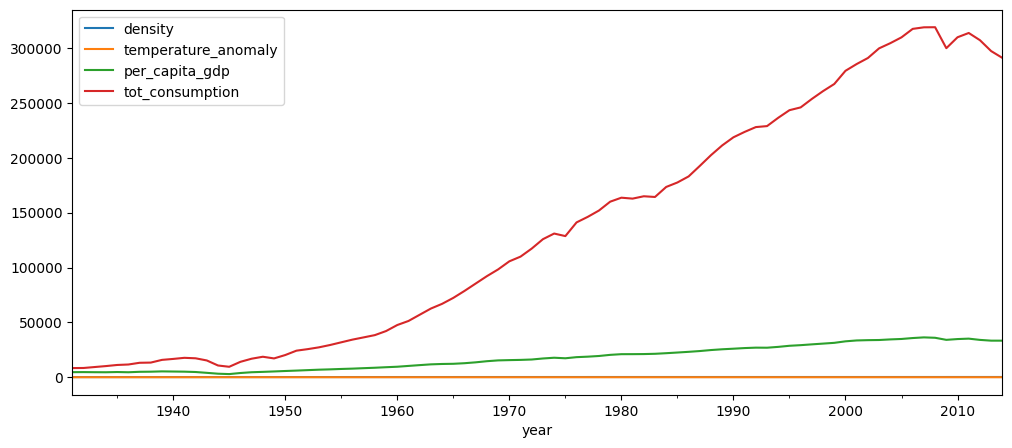

In [1459]:
var_data.plot()

# var model

## stationarity test

In [1460]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [1461]:
grangers_causation_matrix(var_data,variables = var_data.columns)

,density_x,temperature_anomaly_x,per_capita_gdp_x,tot_consumption_x
density_y,1.0000,0.0629,0.008,0.0054
temperature_anomaly_y,0.0007,1.0000,0.000,0.0001
per_capita_gdp_y,0.0000,0.2058,1.000,0.0025
tot_consumption_y,0.0001,0.4492,0.000,1.0000


In [1462]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())         
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
    return out

In [1463]:
adf_results = {}
for var in var_data.columns:
    print('-----------------------------------------------------------------')
    adf_results[var] = adf_test(var_data[var],title=var)

-----------------------------------------------------------------
Augmented Dickey-Fuller Test: density
ADF test statistic      -2.107708
p-value                  0.241427
# lags used              6.000000
# observations          77.000000
critical value (1%)     -3.518281
critical value (5%)     -2.899878
critical value (10%)    -2.587223
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
-----------------------------------------------------------------
Augmented Dickey-Fuller Test: temperature_anomaly
ADF test statistic      -1.706479
p-value                  0.427777
# lags used              3.000000
# observations          80.000000
critical value (1%)     -3.514869
critical value (5%)     -2.898409
critical value (10%)    -2.586439
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
----------------------------------------------------------------

In [1464]:
for var,result in adf_results.items():
    print(f"{var}: p-value = {result['p-value']}")

density: p-value = 0.24142654833871208
temperature_anomaly: p-value = 0.4277772390133839
per_capita_gdp: p-value = 0.8937172157977287
tot_consumption: p-value = 0.4686658189700953


In [1465]:
def adf_test_(series):
    result = adfuller(series.dropna(), autolag='AIC')
    return result[1]  # return only the p-value

stationary_data = var_data.copy()
diff_count = {col: 0 for col in stationary_data.columns}

# Loop through each column
for col in stationary_data.columns:
    pval = adf_test_(stationary_data[col])
    
    # Keep differencing until the series becomes stationary
    while pval > 0.05:
        stationary_data[col] = stationary_data[col].diff()
        diff_count[col] += 1
        pval = adf_test_(stationary_data[col])

        print(f"{col}: differenced {diff_count[col]} time(s), p-value = {pval:.4f}")

stationary_data = stationary_data.dropna()

print("\nNumber of differences applied per variable:")
print(pd.Series(diff_count))

print("\nStationary DataFrame ready for VAR model:")
print(stationary_data.head())

density: differenced 1 time(s), p-value = 0.2120
density: differenced 2 time(s), p-value = 0.0085
temperature_anomaly: differenced 1 time(s), p-value = 0.0000
per_capita_gdp: differenced 1 time(s), p-value = 0.0225
tot_consumption: differenced 1 time(s), p-value = 0.5168
tot_consumption: differenced 2 time(s), p-value = 0.0000

Number of differences applied per variable:
density                2
temperature_anomaly    1
per_capita_gdp         1
tot_consumption        2
dtype: int64

Stationary DataFrame ready for VAR model:
            density  temperature_anomaly  per_capita_gdp  tot_consumption
year                                                                     
1933-01-01  0.00049             0.163739      -92.025960            788.0
1934-01-01  0.00971            -0.026602      -49.723762             -7.0
1935-01-01  0.00975            -0.059974      204.896660            143.0
1936-01-01  0.00989             0.090599     -205.272404           -589.0
1937-01-01  0.00992       

In [1466]:
stationary_data.head()

,density,temperature_anomaly,per_capita_gdp,tot_consumption
year,,,,
1933-01-01,0.00049,0.163739,-92.025960,788.0
1934-01-01,0.00971,-0.026602,-49.723762,-7.0
1935-01-01,0.00975,-0.059974,204.896660,143.0
1936-01-01,0.00989,0.090599,-205.272404,-589.0
1937-01-01,0.00992,-0.007782,408.417955,1152.0


In [1467]:
adf_results = {}
for var in stationary_data.columns:
    print('-----------------------------------------------------------------')
    adf_results[var] = adf_test(stationary_data[var],title=var)

-----------------------------------------------------------------
Augmented Dickey-Fuller Test: density
ADF test statistic      -3.479462
p-value                  0.008530
# lags used              7.000000
# observations          74.000000
critical value (1%)     -3.521980
critical value (5%)     -2.901470
critical value (10%)    -2.588072
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
-----------------------------------------------------------------
Augmented Dickey-Fuller Test: temperature_anomaly
ADF test statistic     -7.486480e+00
p-value                 4.624652e-11
# lags used             2.000000e+00
# observations          7.900000e+01
critical value (1%)    -3.515977e+00
critical value (5%)    -2.898886e+00
critical value (10%)   -2.586694e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
-------------------------------------------------------------

## var model

In [1468]:
model = VAR(stationary_data)
for i in [1,2,3,4,5,6,7,8,9,10]:
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
AIC:  24.041131863585793
BIC:  24.632353877085162

Order = 2
AIC:  23.95861381372685
BIC:  25.030525799330096

Order = 3
AIC:  24.1816332034858
BIC:  25.74126976460333

Order = 4
AIC:  24.379523931114726
BIC:  26.434090600536422

Order = 5
AIC:  24.378454019732352
BIC:  26.93533266175455

Order = 6
AIC:  24.417426235815622
BIC:  27.484180630929217

Order = 7
AIC:  24.42255653121576
BIC:  28.006938146818587

Order = 8
AIC:  24.59794344859174
BIC:  28.70789739863161

Order = 9
AIC:  24.758827276332127
BIC:  29.40249847208503

Order = 10
AIC:  24.54994569747806
BIC:  29.735685190792406



In [1469]:
result = model.fit(2)

In [1470]:
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 17, Apr, 2025
Time:                     23:33:09
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    25.0305
Nobs:                     80.0000    HQIC:                   24.3884
Log likelihood:          -1376.40    FPE:                2.55126e+10
AIC:                      23.9586    Det(Omega_mle):     1.66554e+10
--------------------------------------------------------------------
Results for equation density
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                         -0.069885         0.040079           -1.744           0.081
L1.density                    -0.027072         0.111834           -0.242           0.809
L1.temperature_anomaly

In [1471]:
lag_order = results.k_ar
lag_order

10

In [1472]:
z = results.forecast(y=stationary_data.values[-lag_order:],steps=5)
z

array([[ 7.87756663e-02,  7.41744958e-01, -1.29669437e+01,
         4.19326605e+03],
       [-6.32133097e-01,  1.09037090e+00,  1.77616449e+02,
         6.06895172e+03],
       [-4.31413207e-01, -1.34767824e+00, -3.92927863e+02,
        -1.17892367e+04],
       [ 4.39657520e-01, -3.34647782e-01,  8.69473472e+02,
         1.22565541e+04],
       [-9.38393422e-02,  5.88924407e-01,  8.57956255e+02,
        -1.25788170e+03]])

In [1473]:
idx = pd.date_range('2014-01-01',periods=5, freq='YS')

In [1474]:
var_data.columns

Index(['density', 'temperature_anomaly', 'per_capita_gdp', 'tot_consumption'], dtype='object')

In [1475]:
df_forecast = pd.DataFrame(z, index=idx,
                           columns=['density2d','temperature_anomaly2d','per_capita_gdp2d','tot_consumption2d'])

In [1476]:
df_forecast

,density2d,temperature_anomaly2d,per_capita_gdp2d,tot_consumption2d
2014-01-01,0.078776,0.741745,-12.966944,4193.266047
2015-01-01,-0.632133,1.090371,177.616449,6068.951716
2016-01-01,-0.431413,-1.347678,-392.927863,-11789.236669
2017-01-01,0.439658,-0.334648,869.473472,12256.554051
2018-01-01,-0.093839,0.588924,857.956255,-1257.881696


<Axes: >

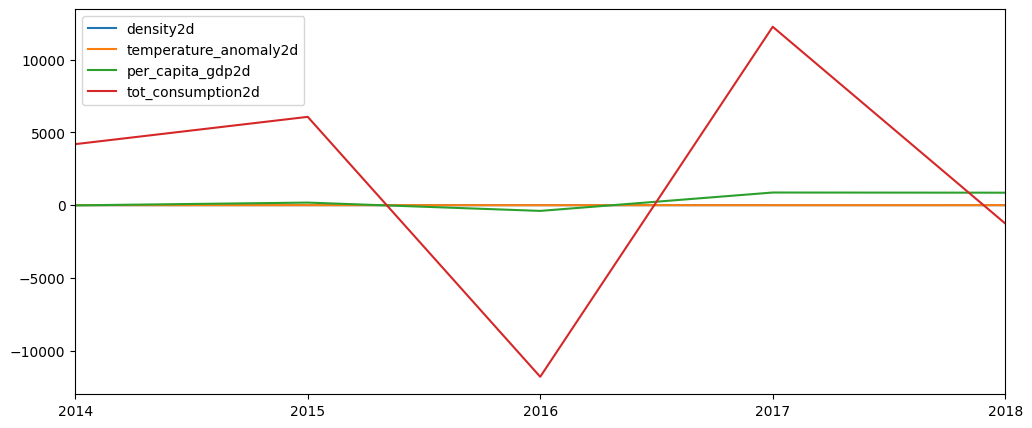

In [1477]:
df_forecast.plot()

In [1478]:
df_forecast['density1d'] = (var_data['density'].iloc[-5]-var_data['density'].iloc[-6]) + df_forecast['density2d'].cumsum()

df_forecast['densityForecast'] = var_data['density'].iloc[-5] + df_forecast['density1d'].cumsum()

In [1479]:
df_forecast['per_capita_gdp1d'] = (var_data['per_capita_gdp'].iloc[-5]-var_data['per_capita_gdp'].iloc[-6]) + df_forecast['per_capita_gdp2d'].cumsum()

df_forecast['per_capita_gdpForecast'] = var_data['per_capita_gdp'].iloc[-5] + df_forecast['per_capita_gdp1d'].cumsum()

In [1480]:
df_forecast['temperature_anomaly1d'] = (var_data['temperature_anomaly'].iloc[-5]-var_data['temperature_anomaly'].iloc[-6]) + df_forecast['temperature_anomaly2d'].cumsum()

df_forecast['temperature_anomalyForecast'] = var_data['temperature_anomaly'].iloc[-5] + df_forecast['temperature_anomaly1d'].cumsum()

In [1481]:
df_forecast['tot_consumption1d'] = (var_data['tot_consumption'].iloc[-5]-var_data['tot_consumption'].iloc[-6]) + df_forecast['tot_consumption2d'].cumsum()

df_forecast['tot_consumptionForecast'] = var_data['tot_consumption'].iloc[-5] + df_forecast['tot_consumption1d'].cumsum()

In [1482]:
df_forecast

,density2d,temperature_anomaly2d,per_capita_gdp2d,tot_consumption2d,density1d,densityForecast,per_capita_gdp1d,per_capita_gdpForecast,temperature_anomaly1d,temperature_anomalyForecast,tot_consumption1d,tot_consumptionForecast
2014-01-01,0.078776,0.741745,-12.966944,4193.266047,0.958656,204.410466,700.466714,35479.147535,0.057113,-0.470018,14163.266047,324048.266047
2015-01-01,-0.632133,1.090371,177.616449,6068.951716,0.326523,204.736988,878.083162,36357.230697,1.147484,0.677466,20232.217763,344280.483810
2016-01-01,-0.431413,-1.347678,-392.927863,-11789.236669,-0.104891,204.632098,485.155299,36842.385996,-0.200194,0.477272,8442.981094,352723.464905
2017-01-01,0.439658,-0.334648,869.473472,12256.554051,0.334767,204.966864,1354.628771,38197.014768,-0.534842,-0.057570,20699.535145,373423.000050
2018-01-01,-0.093839,0.588924,857.956255,-1257.881696,0.240928,205.207792,2212.585027,40409.599794,0.054083,-0.003488,19441.653449,392864.653499


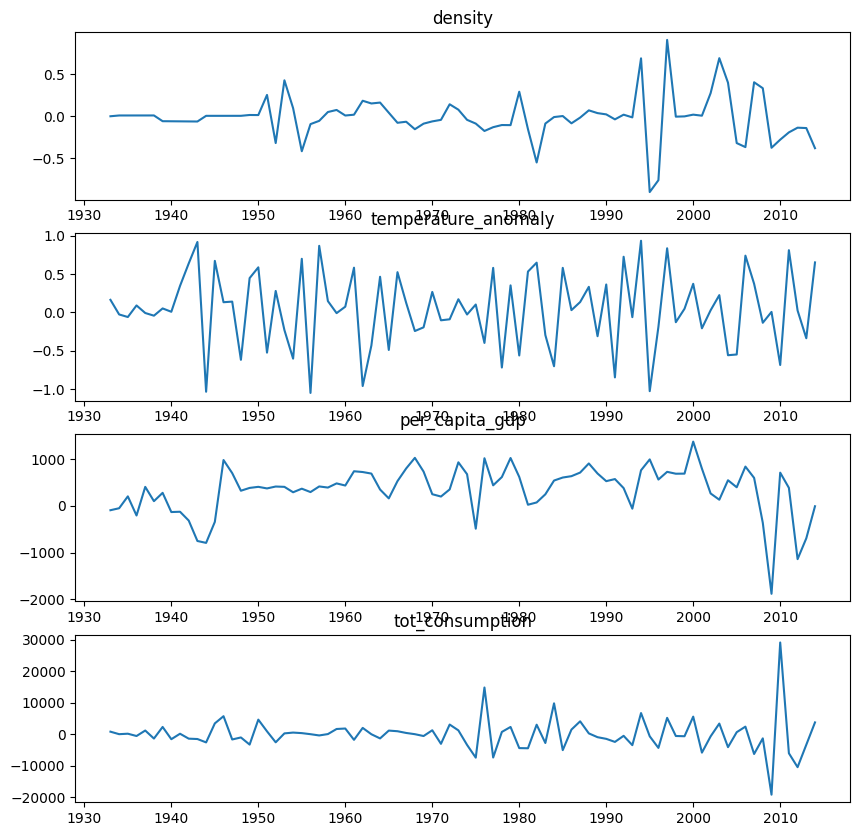

In [1483]:
results.plot();

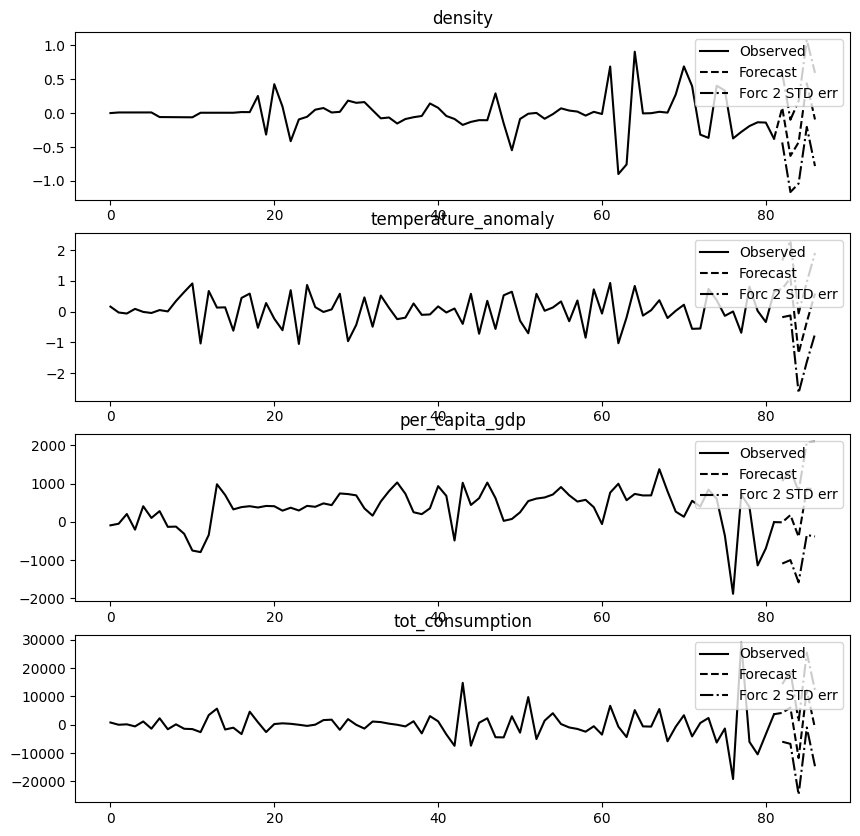

In [1484]:
results.plot_forecast(5);

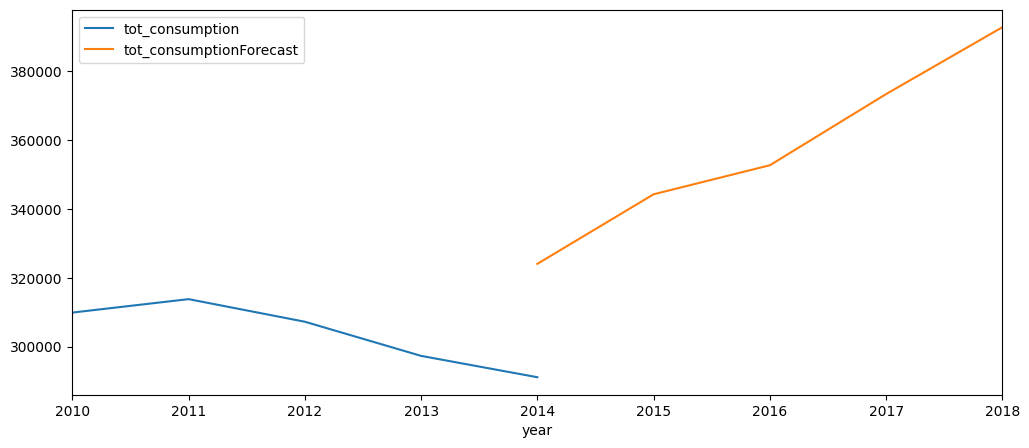

In [1486]:
var_data['tot_consumption'][-5:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['tot_consumptionForecast'].plot(legend=True);

In [1488]:
RMSE1 = rmse(var_data['tot_consumption'][-5:], df_forecast['tot_consumptionForecast'])
RMSE1

62219.853307231264